In [11]:
# Import Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Display settings
pd.set_option('display.precision', 4)
sns.set(style="whitegrid", font_scale=1.1)

# Load All CSV Files
files = [
    "./results/metrics/decision_tree.csv",
    "./results/metrics/knn.csv",
    "./results/metrics/logistic_regression.csv",
    "./results/metrics/mlp.csv",
    "./results/metrics/random_forest.csv",
    "./results/metrics/xgboost.csv"
]

In [12]:
# Read and merge data
dataframes = []
for file in files:
    df = pd.read_csv(file)
    dataframes.append(df)

# Combine all models
combined_df = pd.concat(dataframes, ignore_index=True)
print("Data Loaded - Total Records:", len(combined_df))
combined_df.head()

Data Loaded - Total Records: 12


,Model,Accuracy,Precision,Recall,F1_Score,AUC_ROC
0,Decision Tree - Baseline,0.6838,0.6886,0.6710,0.6797,0.6838
1,Decision Tree - Tuned,0.7127,0.6750,0.8202,0.7406,0.7600
2,KNN - Baseline,0.7325,0.7107,0.7842,0.7456,0.7938
3,KNN - Tuned,0.7491,0.7137,0.8319,0.7683,0.7981
4,Logistic Regression - Baseline,0.8017,0.7160,1.0000,0.8345,0.8003


In [13]:
# Data Preparation
# Extract model name and version (e.g., "Decision Tree" & "Baseline")
combined_df['Model_Name'] = combined_df['Model'].apply(lambda x: x.split(' - ')[0].strip())
combined_df['Version'] = combined_df['Model'].apply(lambda x: x.split(' - ')[1].strip())

# Reorder columns for clarity
cols = ['Model_Name', 'Version', 'Accuracy', 'Precision', 'Recall', 'F1_Score', 'AUC_ROC']
combined_df = combined_df[cols]
print(combined_df)

             Model_Name   Version  Accuracy  Precision  Recall  F1_Score  \
0         Decision Tree  Baseline    0.6838     0.6886  0.6710    0.6797   
1         Decision Tree     Tuned    0.7127     0.6750  0.8202    0.7406   
2                   KNN  Baseline    0.7325     0.7107  0.7842    0.7456   
3                   KNN     Tuned    0.7491     0.7137  0.8319    0.7683   
4   Logistic Regression  Baseline    0.8017     0.7160  1.0000    0.8345   
5   Logistic Regression     Tuned    0.8017     0.7160  1.0000    0.8345   
6                   MLP  Baseline    0.8017     0.7160  1.0000    0.8345   
7                   MLP     Tuned    0.8017     0.7160  1.0000    0.8345   
8         Random Forest  Baseline    0.7124     0.7137  0.7092    0.7115   
9         Random Forest     Tuned    0.7217     0.7153  0.7363    0.7257   
10              XGBoost  Baseline    0.8006     0.7159  0.9965    0.8332   
11              XGBoost     Tuned    0.8015     0.7158  0.9999    0.8344   

    AUC_ROC

In [14]:
# Best Model per Metric
metrics = ['Accuracy', 'Precision', 'Recall', 'F1_Score', 'AUC_ROC']

best_models = []
for metric in metrics:
    idx = combined_df[metric].idxmax()
    row = combined_df.loc[idx, ['Model_Name', 'Version', metric]]
    best_models.append(row)

best_models_df = pd.DataFrame(best_models).set_index(pd.Index(metrics))
print(best_models_df)

                    Model_Name   Version  Accuracy  Precision  Recall  \
Accuracy   Logistic Regression  Baseline    0.8017        NaN     NaN   
Precision  Logistic Regression  Baseline       NaN      0.716     NaN   
Recall     Logistic Regression  Baseline       NaN        NaN     1.0   
F1_Score   Logistic Regression  Baseline       NaN        NaN     NaN   
AUC_ROC                XGBoost  Baseline       NaN        NaN     NaN   

           F1_Score  AUC_ROC  
Accuracy        NaN      NaN  
Precision       NaN      NaN  
Recall          NaN      NaN  
F1_Score     0.8345      NaN  
AUC_ROC         NaN   0.8029  


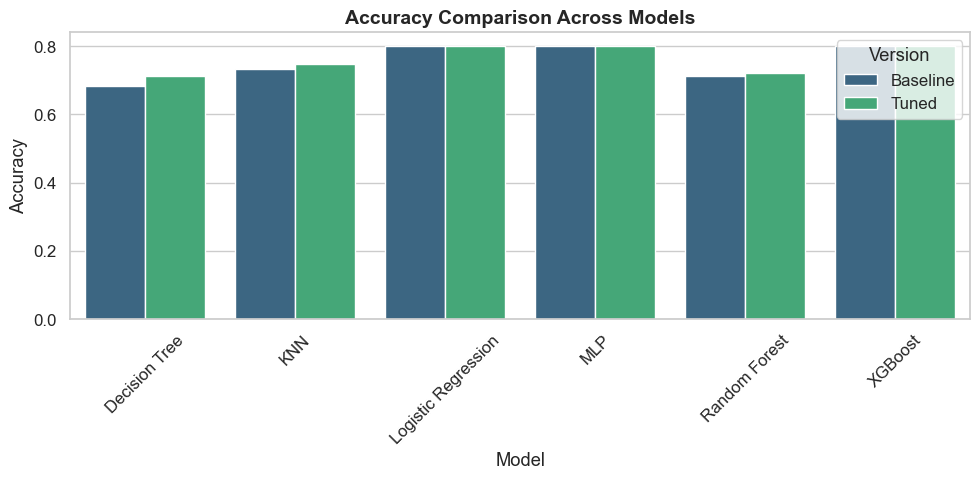

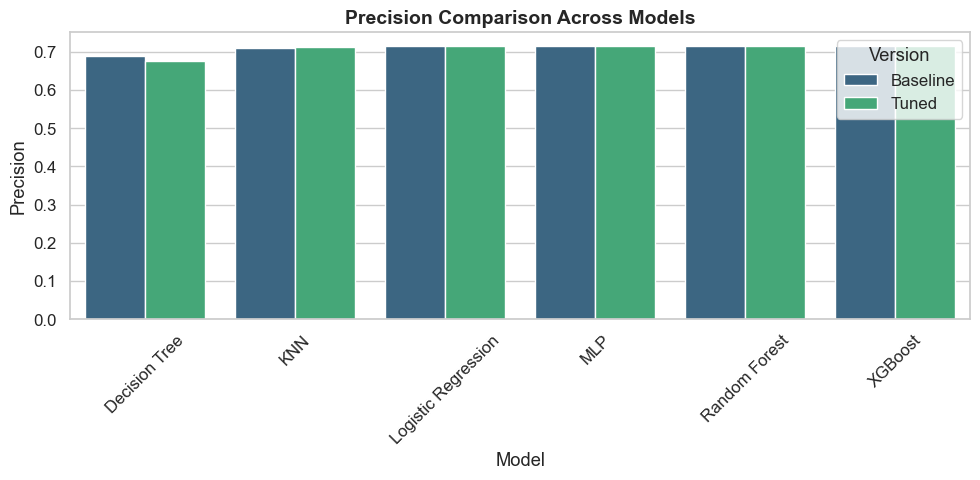

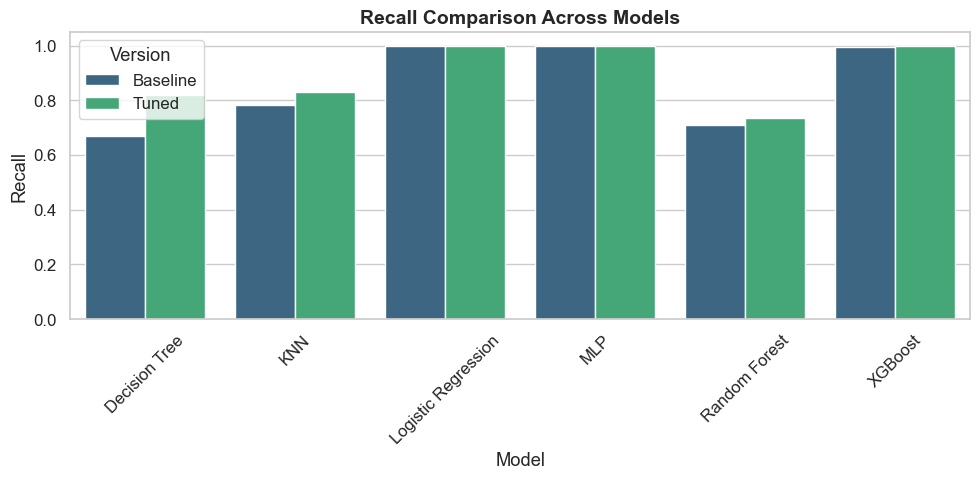

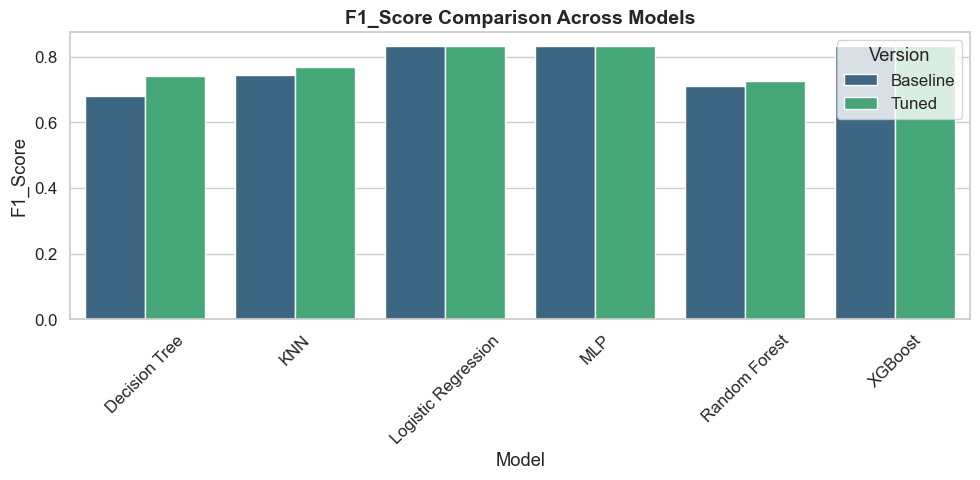

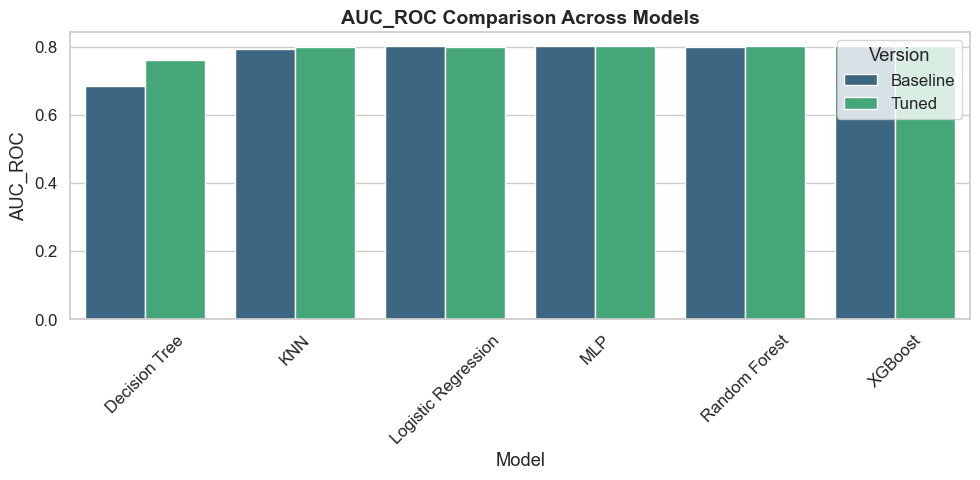

In [15]:
# Metric Comparison Visualizations
for metric in metrics:
    plt.figure(figsize=(10, 5))
    sns.barplot(
        data=combined_df,
        x='Model_Name', y=metric, hue='Version',
        palette='viridis'
    )
    plt.title(f'{metric} Comparison Across Models', fontsize=14, fontweight='bold')
    plt.ylabel(metric)
    plt.xlabel('Model')
    plt.xticks(rotation=45)
    plt.legend(title='Version')
    plt.tight_layout()
    plt.show()

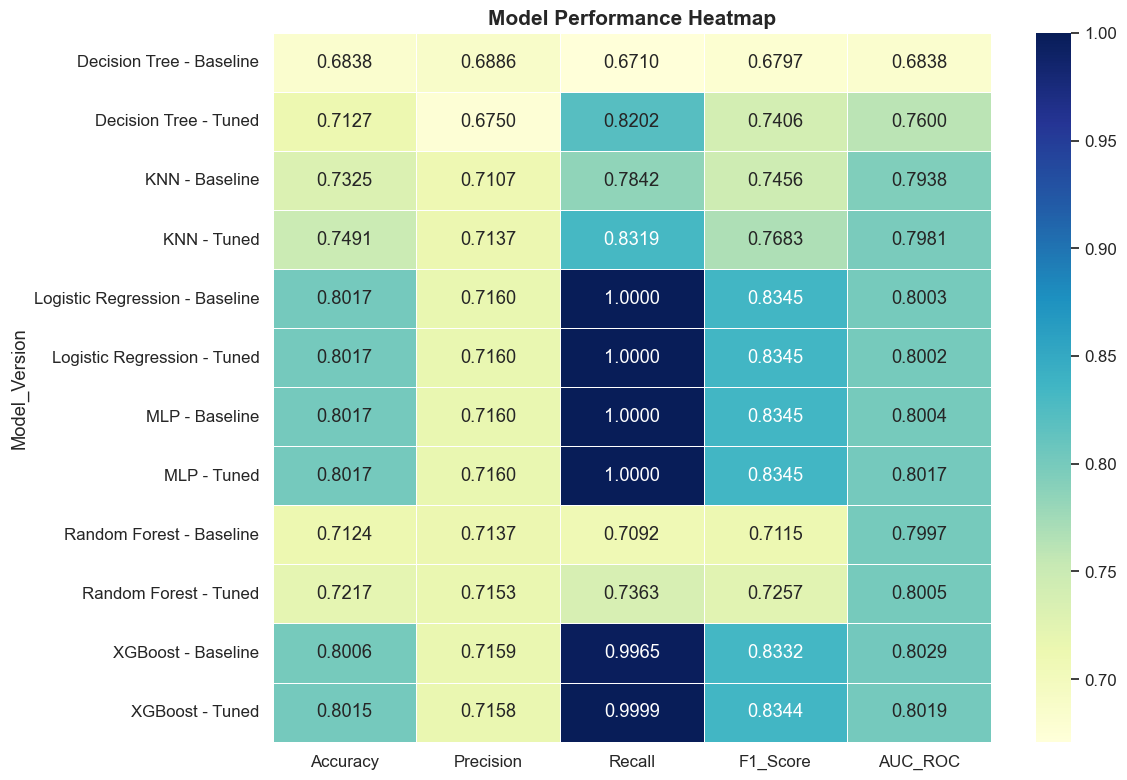

In [16]:
# Performance Heatmap
combined_df['Model_Version'] = combined_df['Model_Name'] + ' - ' + combined_df['Version']
heatmap_data = combined_df.set_index('Model_Version')[metrics]

plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, annot=True, cmap='YlGnBu', fmt='.4f', linewidths=.5)
plt.title('Model Performance Heatmap', fontsize=15, fontweight='bold')
plt.tight_layout()
plt.show()

In [17]:
# Print Best Model per Metric
print("Best Model per Metric:")
for metric in metrics:
    best_row = combined_df.loc[combined_df[metric].idxmax()]
    print(f"• {metric}: {best_row['Model_Name']} - {best_row['Version']} ({best_row[metric]:.4f})")

Best Model per Metric:
• Accuracy: Logistic Regression - Baseline (0.8017)
• Precision: Logistic Regression - Baseline (0.7160)
• Recall: Logistic Regression - Baseline (1.0000)
• F1_Score: Logistic Regression - Baseline (0.8345)
• AUC_ROC: XGBoost - Baseline (0.8029)


In [18]:
# Overall Best Model (All Metrics Combined)
overall_df = (
    combined_df.groupby(['Model_Name', 'Version'])[metrics]
    .mean()
    .reset_index()
)

# Normalize metrics to [0, 1] for fair comparison
normalized_df = overall_df.copy()
for metric in metrics:
    min_val, max_val = normalized_df[metric].min(), normalized_df[metric].max()
    normalized_df[metric] = (normalized_df[metric] - min_val) / (max_val - min_val)

# Compute mean score
normalized_df['Overall_Score'] = normalized_df[metrics].mean(axis=1)

# Find best model
best_overall = normalized_df.loc[normalized_df['Overall_Score'].idxmax()]

print("\nBest Overall Model (Across All Metrics):")
print(f"Model: {best_overall['Model_Name']} - {best_overall['Version']}")
print(f"Overall Score: {best_overall['Overall_Score']:.4f}")


Best Overall Model (Across All Metrics):
Model: MLP - Tuned
Overall Score: 0.9979


C:\Users\KHThi\AppData\Local\Temp\ipykernel_21264\3929921512.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


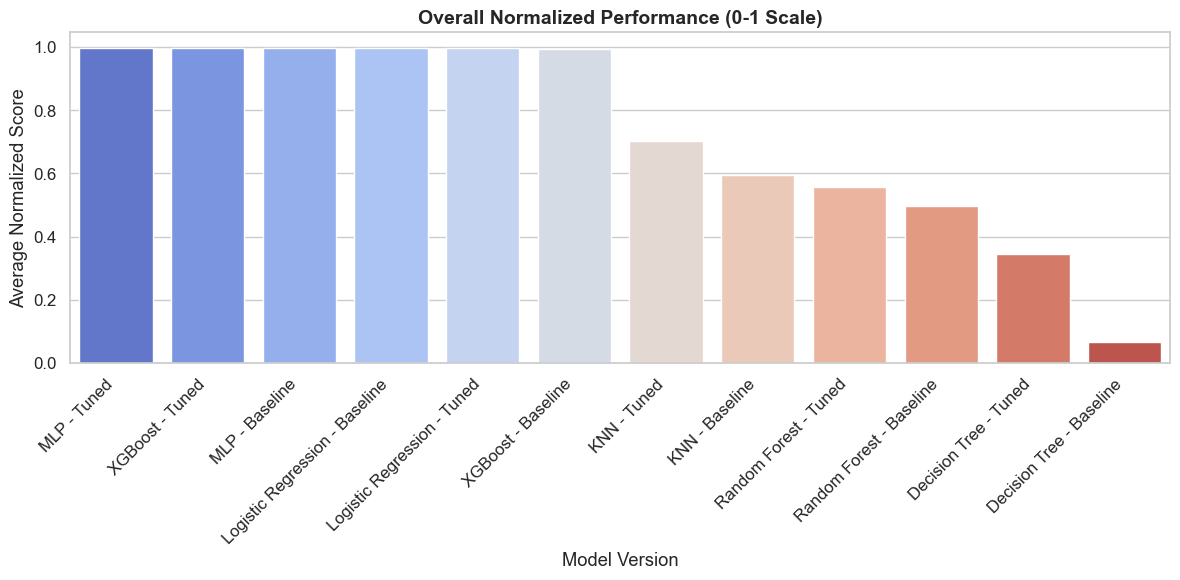

In [19]:
# Plot Overall Performance
plt.figure(figsize=(12, 6))
normalized_df['Model_Version'] = normalized_df['Model_Name'] + ' - ' + normalized_df['Version']
sns.barplot(
    data=normalized_df.sort_values('Overall_Score', ascending=False),
    x='Model_Version', y='Overall_Score', palette='coolwarm'
)
plt.title('Overall Normalized Performance (0-1 Scale)', fontsize=14, fontweight='bold')
plt.ylabel('Average Normalized Score')
plt.xlabel('Model Version')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [20]:
# Top 5 Models Summary
top5 = normalized_df.sort_values('Overall_Score', ascending=False).head(5)
print("\nTop 5 Overall Models:")
for idx, row in top5.iterrows():
    print(f"{row['Model_Name']} - {row['Version']}: {row['Overall_Score']:.4f}")


Top 5 Overall Models:
MLP - Tuned: 0.9979
XGBoost - Tuned: 0.9965
MLP - Baseline: 0.9959
Logistic Regression - Baseline: 0.9957
Logistic Regression - Tuned: 0.9955
